In [1]:
seed = 3906303

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

import gzip
import random
np.random.seed(seed)
random.seed(seed)

In [3]:
df_icu_filtered = pd.read_csv("bg_filtered_chartevents.csv")
df_icu_filtered

,Unnamed: 0,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,0,10000032,29079034,39553978,NaN,2180-07-23 21:45:00,2180-07-23 22:30:00,220621,115.0,115.0,mg/dL,1
1,1,10000690,25860671,37081114,84407.0,2150-11-04 10:00:00,2150-11-04 09:39:00,225664,117.0,117.0,NaN,0
2,2,10000690,25860671,37081114,NaN,2150-11-03 02:56:00,2150-11-03 04:22:00,220621,77.0,77.0,mg/dL,0
3,3,10000690,25860671,37081114,NaN,2150-11-04 03:03:00,2150-11-04 03:44:00,220621,84.0,84.0,mg/dL,0
4,4,10000690,25860671,37081114,NaN,2150-11-04 17:54:00,2150-11-04 18:41:00,220621,120.0,120.0,mg/dL,1
...,...,...,...,...,...,...,...,...,...,...,...,...
361863,1814451,19999840,21033226,38978960,NaN,2164-09-17 08:11:00,2164-09-17 08:14:00,226537,166.0,166.0,mg/dL,1
361864,1814452,19999840,21033226,38978960,NaN,2164-09-17 13:13:00,2164-09-17 13:53:00,220621,146.0,146.0,mg/dL,1
361865,1814453,19999840,21033226,38978960,NaN,2164-09-17 13:18:00,2164-09-17 13:28:00,226537,139.0,139.0,mg/dL,1
361866,1814454,19999840,21033226,38978960,NaN,2164-09-17 13:34:00,2164-09-17 13:37:00,226537,275.0,275.0,mg/dL,1


In [4]:
df_icu_filtered.drop(columns=['Unnamed: 0'], inplace = True)

In [5]:
bg_icu = df_icu_filtered
bg_icu.sort_values(by=['subject_id', 'charttime'])

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10000032,29079034,39553978,NaN,2180-07-23 21:45:00,2180-07-23 22:30:00,220621,115.0,115.0,mg/dL,1
2,10000690,25860671,37081114,NaN,2150-11-03 02:56:00,2150-11-03 04:22:00,220621,77.0,77.0,mg/dL,0
3,10000690,25860671,37081114,NaN,2150-11-04 03:03:00,2150-11-04 03:44:00,220621,84.0,84.0,mg/dL,0
1,10000690,25860671,37081114,84407.0,2150-11-04 10:00:00,2150-11-04 09:39:00,225664,117.0,117.0,NaN,0
4,10000690,25860671,37081114,NaN,2150-11-04 17:54:00,2150-11-04 18:41:00,220621,120.0,120.0,mg/dL,1
...,...,...,...,...,...,...,...,...,...,...,...
361852,19999840,21033226,38978960,93123.0,2164-09-17 09:00:00,2164-09-17 09:30:00,225664,179.0,179.0,NaN,0
361864,19999840,21033226,38978960,NaN,2164-09-17 13:13:00,2164-09-17 13:53:00,220621,146.0,146.0,mg/dL,1
361865,19999840,21033226,38978960,NaN,2164-09-17 13:18:00,2164-09-17 13:28:00,226537,139.0,139.0,mg/dL,1
361866,19999840,21033226,38978960,NaN,2164-09-17 13:34:00,2164-09-17 13:37:00,226537,275.0,275.0,mg/dL,1


In [6]:
bg_icu.sort_values(by=['value'], ascending=False).head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
86572,12468016,25074766,37541173,NaN,2138-12-11 08:46:00,2138-12-11 08:53:00,226537,1276100.0,1276100.0,mg/dL,1
143781,14001477,21798613,39305258,NaN,2129-08-14 18:39:00,2129-08-14 20:23:00,220621,999999.0,999999.0,mg/dL,0
177138,14973395,26267783,30262829,NaN,2143-03-06 19:15:00,2143-03-07 11:21:00,220621,999999.0,999999.0,NaN,0
159410,14432295,25310293,38536639,NaN,2184-09-03 15:43:00,2184-09-03 16:51:00,226537,999999.0,999999.0,mg/dL,0
29196,10861654,29147507,34719569,NaN,2123-12-26 01:09:00,2123-12-26 05:18:00,220621,999999.0,999999.0,mg/dL,0


In [7]:
bg_icu['charttime'] = pd.to_datetime(
    bg_icu['charttime'],
    format='%Y-%m-%d %H:%M:%S',   # matches 2180-07-23 21:45:00
    errors='raise'               # or 'coerce' to turn bad rows into NaT
)
bg_icu['storetime'] = pd.to_datetime(
    bg_icu['storetime'],
    format='%Y-%m-%d %H:%M:%S',   # matches 2180-07-23 21:45:00
    errors='raise'               # or 'coerce' to turn bad rows into NaT
)

In [8]:
bg_icu['valueuom'].value_counts()

mg/dL    153117
Name: valueuom, dtype: int64

In [9]:
print(bg_icu[bg_icu['value'] < 2656].shape)
print(bg_icu[bg_icu['value'] > 2656].shape)

(361837, 11)
(31, 11)


In [10]:
bg_icu = bg_icu[(bg_icu['value'] < 2656) & (bg_icu['value'] > 10)]

In [11]:
bg_icu.sort_values(by=['value'], ascending=False).head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
210625,15816613,20786142,37630991,NaN,2181-11-23 02:04:00,2181-11-23 03:25:00,220621,2474.0,2474.0,mg/dL,1
158368,14392310,22267572,30763023,NaN,2178-08-13 01:44:00,2178-08-13 02:51:00,220621,2440.0,2440.0,mg/dL,1
196787,15465739,28798031,38185691,NaN,2137-03-14 17:18:00,2137-03-14 20:33:00,220621,2323.0,2323.0,mg/dL,1
156738,14363499,28723335,38277295,NaN,2124-10-03 16:50:00,2124-10-03 18:40:00,220621,2190.0,2190.0,mg/dL,1
19573,10636904,22554647,32199838,NaN,2112-07-08 04:31:00,2112-07-08 06:20:00,220621,1980.0,1980.0,mg/dL,1


In [12]:
bg_icu['subject_id'].nunique()

16616

In [13]:
bg_icu['subject_id'].nunique()

16616

# Split Dataset into Training, Validation and Testing Datasets

In [14]:
# Get unique patient ids
unique_subjects = bg_icu['subject_id'].unique()

train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.2, random_state=seed)
train_subjects, test_subjects

(array([13272956, 13985229, 13777050, ..., 15899798, 13665139, 13399590],
       dtype=int64),
 array([13387877, 15023828, 13276225, ..., 17078260, 17721420, 11626382],
       dtype=int64))

In [15]:
train_subjects, val_subjects = train_test_split(train_subjects, test_size=0.25, random_state=seed)

In [16]:
bg_icu['subject_id'].isin(test_subjects).sum()

73450

In [17]:
bg_icu['subject_id'].isin(train_subjects).sum()

216452

In [18]:
bg_icu['valueuom'].isna().sum()

208708

### Creating sequenced data

Here we create the data to be fed into the model. Each row of data in the X datasets is a sequence of BG measurements. The Y datasets contain a BG reading that follows directly from that sequence after.

The approach we took is so that a sequence of measurements (starting from the first) is created of certain length from each ICU admission, which is taken as the X, and the following value after the sequence is taken as the Y. Then the window is slid over by one so that the sequence is slightly different, creating a new X value and a new following Y value. This process is repeated until the end of the ICU admission measurement sequence is reached, then a new ICU admission is chosen, until all ICU admissions have had their sequences recorded.

In [19]:
df_train = bg_icu[bg_icu['subject_id'].isin(train_subjects)]
df_train.head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10000032,29079034,39553978,NaN,2180-07-23 21:45:00,2180-07-23 22:30:00,220621,115.0,115.0,mg/dL,1
1,10000690,25860671,37081114,84407.0,2150-11-04 10:00:00,2150-11-04 09:39:00,225664,117.0,117.0,NaN,0
2,10000690,25860671,37081114,NaN,2150-11-03 02:56:00,2150-11-03 04:22:00,220621,77.0,77.0,mg/dL,0
3,10000690,25860671,37081114,NaN,2150-11-04 03:03:00,2150-11-04 03:44:00,220621,84.0,84.0,mg/dL,0
4,10000690,25860671,37081114,NaN,2150-11-04 17:54:00,2150-11-04 18:41:00,220621,120.0,120.0,mg/dL,1


In [20]:
df_val = bg_icu[bg_icu['subject_id'].isin(val_subjects)]
df_val.head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
19,10002155,23822395,33685454,NaN,2129-08-04 17:56:00,2129-08-04 18:51:00,220621,95.0,95.0,mg/dL,0
20,10002155,23822395,33685454,NaN,2129-08-05 05:01:00,2129-08-05 07:04:00,220621,107.0,107.0,mg/dL,1
21,10002155,23822395,33685454,NaN,2129-08-06 06:05:00,2129-08-06 08:00:00,220621,106.0,106.0,mg/dL,1
22,10002155,23822395,33685454,NaN,2129-08-07 04:19:00,2129-08-07 05:14:00,220621,116.0,116.0,mg/dL,1
23,10002155,23822395,33685454,NaN,2129-08-08 05:46:00,2129-08-08 06:43:00,220621,102.0,102.0,mg/dL,0


In [21]:
df_test = bg_icu[bg_icu['subject_id'].isin(test_subjects)]
df_test.head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
39,10003400,23559586,38383343,6319.0,2137-08-18 22:00:00,2137-08-18 22:14:00,225664,106.0,106.0,NaN,0
40,10003400,23559586,38383343,40034.0,2137-08-28 22:00:00,2137-08-29 00:48:00,225664,86.0,86.0,NaN,0
41,10003400,23559586,38383343,51221.0,2137-08-24 23:00:00,2137-08-25 00:08:00,225664,147.0,147.0,NaN,0
42,10003400,23559586,38383343,69088.0,2137-08-21 12:00:00,2137-08-21 12:15:00,225664,103.0,103.0,NaN,0
43,10003400,23559586,38383343,69088.0,2137-08-21 16:00:00,2137-08-21 16:22:00,225664,105.0,105.0,NaN,0


In [22]:
df_train.sort_values(by=['subject_id','hadm_id','charttime'])

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10000032,29079034,39553978,NaN,2180-07-23 21:45:00,2180-07-23 22:30:00,220621,115.0,115.0,mg/dL,1
2,10000690,25860671,37081114,NaN,2150-11-03 02:56:00,2150-11-03 04:22:00,220621,77.0,77.0,mg/dL,0
3,10000690,25860671,37081114,NaN,2150-11-04 03:03:00,2150-11-04 03:44:00,220621,84.0,84.0,mg/dL,0
1,10000690,25860671,37081114,84407.0,2150-11-04 10:00:00,2150-11-04 09:39:00,225664,117.0,117.0,NaN,0
4,10000690,25860671,37081114,NaN,2150-11-04 17:54:00,2150-11-04 18:41:00,220621,120.0,120.0,mg/dL,1
...,...,...,...,...,...,...,...,...,...,...,...
361852,19999840,21033226,38978960,93123.0,2164-09-17 09:00:00,2164-09-17 09:30:00,225664,179.0,179.0,NaN,0
361864,19999840,21033226,38978960,NaN,2164-09-17 13:13:00,2164-09-17 13:53:00,220621,146.0,146.0,mg/dL,1
361865,19999840,21033226,38978960,NaN,2164-09-17 13:18:00,2164-09-17 13:28:00,226537,139.0,139.0,mg/dL,1
361866,19999840,21033226,38978960,NaN,2164-09-17 13:34:00,2164-09-17 13:37:00,226537,275.0,275.0,mg/dL,1


### Below we filter out ICU stays that have less than 2 blood glucose measurements, and see the distribution of measurement frequency

In [23]:
df_train['stay_id'].value_counts().describe()

count    11063.000000
mean        19.565398
std         34.489422
min          1.000000
25%          3.000000
50%          9.000000
75%         22.000000
max        735.000000
Name: stay_id, dtype: float64

C:\Users\Mashal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


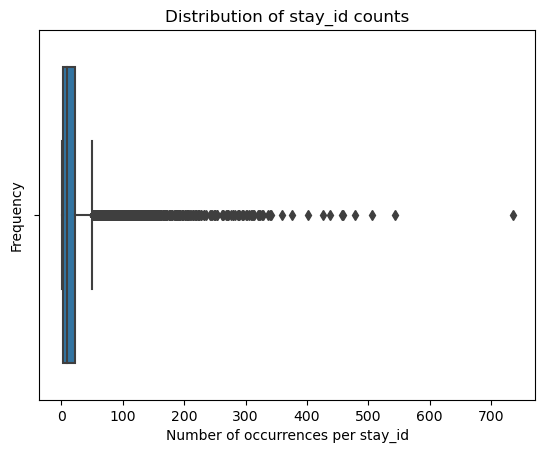

In [24]:
# Get counts
stay_counts = df_train['stay_id'].value_counts()

# Plot histogram of those counts
sns.boxplot(stay_counts)  # Optional: adjust bins

plt.xlabel('Number of occurrences per stay_id')
plt.ylabel('Frequency')
plt.title('Distribution of stay_id counts')
plt.show()


C:\Users\Mashal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


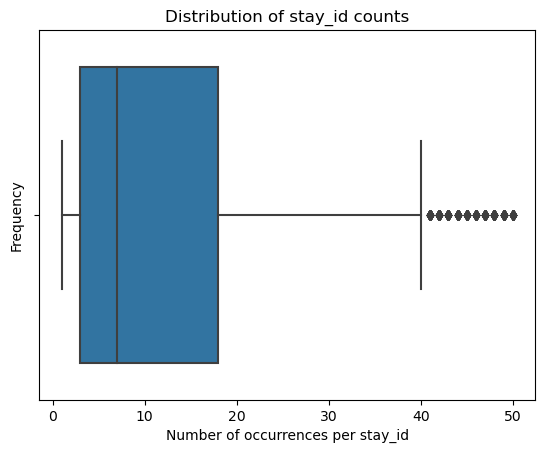

In [25]:
counts = df_train['stay_id'].value_counts()

Q1 = counts.quantile(0.25)
Q3 = counts.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

valid_stays = counts[(counts >= lower_bound) & (counts <= upper_bound)].index

df_filtered = df_train[df_train['stay_id'].isin(valid_stays)]
# Plot boxplot of those counts
sns.boxplot(df_filtered['stay_id'].value_counts())

plt.xlabel('Number of occurrences per stay_id')
plt.ylabel('Frequency')
plt.title('Distribution of stay_id counts')
plt.show()

In [26]:
valid_stays = counts[(counts >= 2)].index
df_train = df_train[df_train['stay_id'].isin(valid_stays)]
df_train['stay_id'].value_counts()

36066456    735
34423873    544
35951721    506
37564059    479
39245279    459
           ... 
30266538      2
32080372      2
39443886      2
32735984      2
37769664      2
Name: stay_id, Length: 10191, dtype: int64

In [27]:
counts = df_val['stay_id'].value_counts()
valid_stays = counts[(counts >= 2)].index
df_val = df_val[df_val['stay_id'].isin(valid_stays)]
df_val['stay_id'].value_counts()

33566920    835
39510663    787
36915287    728
33552034    504
31255716    502
           ... 
37831078      2
37704002      2
32569704      2
32361292      2
32296053      2
Name: stay_id, Length: 3401, dtype: int64

In [28]:
counts = df_test['stay_id'].value_counts()
valid_stays = counts[(counts >= 2)].index
df_test = df_test[df_test['stay_id'].isin(valid_stays)]
df_test['stay_id'].value_counts()

38640772    464
38606468    451
30686497    431
32832800    415
35027838    369
           ... 
33352784      2
38623541      2
34509464      2
33123054      2
30600331      2
Name: stay_id, Length: 3392, dtype: int64

In [29]:
icu_stays = df_train['stay_id'].unique()

In [30]:
df_train['stay_id'].value_counts()

36066456    735
34423873    544
35951721    506
37564059    479
39245279    459
           ... 
30266538      2
32080372      2
39443886      2
32735984      2
37769664      2
Name: stay_id, Length: 10191, dtype: int64

In [31]:
df_train.reset_index(drop=True)[df_train.reset_index(drop=True)['stay_id']==33566920]

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning


In [32]:
df_stay['charttime'].astype('int64')

NameError: name 'df_stay' is not defined

### The below cell creates the data points. X train contains rows of 5 measurements in sequence each, with y train value being the following measurement taken directly after, which is to be predicted.

In [ ]:
X_test = []
y_test = []
for stay_id in icu_stays:
    # Gets the specific ICU stay data
    df_stay = df_test.loc[df_test['stay_id'] == stay_id].sort_values(by=['charttime']).reset_index(drop=True)
    for row in df_stay.itertuples():
        sequence = []
        i = 0
        j = row.Index

        if df_stay.shape[0] < 6 or df_stay.shape[0] - j >= 6:
            # This loop traverses 5 data points or until penultimate dataframe row, whichever comes first,
            # and appends all BG values to the sequence
            while i < 5 and j < df_stay.shape[0] - 1:
                sequence.append(df_stay.at[row.Index + i,'value'])
                i += 1
                j += 1
            if len(sequence) > 0:
                X_test.append(sequence)
                y_test.append(df_stay.at[row.Index + i,'value'])
            # This condition ensures that an icu stay with fewer than 6 measurements is added only once
            if df_stay.shape[0] < 6:
                break

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0.0, input_shape=(None, 1)),  # allow variable time steps
    # Sets hidden and cell state vector shape/size
    tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Create an SGD optimizer
sgd = tf.keras.optimizers.SGD(
        learning_rate=0.01,   # default is 0.01
        momentum=0.9,         # 0.0 = vanilla SGD; 0.9 is common
        nesterov=False        
)

# Compile model with SGD
model.compile(
    loss='mse',
    optimizer=sgd,           
    metrics=['mae']          # any metrics we care about
)


In [ ]:
# pad to max length (say 5)
X_train = pad_sequences(X_train, maxlen=5, dtype='float32', padding='post')

# reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = np.array(y_train, dtype=np.float32)

In [ ]:
import time

start_time = time.time()
print(start_time)
# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds.")

Epoch 1/10
872519/872519 [==============================] - 3076s 4ms/step - loss: 204727.6562 - mae: 46.7486
Epoch 2/10
872519/872519 [==============================] - 2972s 3ms/step - loss: 4046.0701 - mae: 45.3810
Epoch 3/10
872519/872519 [==============================] - 3025s 3ms/step - loss: 4043.6011 - mae: 45.3775
Epoch 4/10
872519/872519 [==============================] - 2946s 3ms/step - loss: 4046.0117 - mae: 45.3933
Epoch 5/10
872519/872519 [==============================] - 2933s 3ms/step - loss: 4046.0637 - mae: 45.4016
Epoch 6/10
872519/872519 [==============================] - 3025s 3ms/step - loss: 4048.3232 - mae: 45.4137
Epoch 7/10
872519/872519 [==============================] - 3047s 3ms/step - loss: 4049.3232 - mae: 45.4207
Epoch 8/10
872519/872519 [==============================] - 2968s 3ms/step - loss: 4047.0815 - mae: 45.4038
Epoch 9/10
872519/872519 [==============================] - 2967s 3ms/step - loss: 4049.4353 - mae: 45.4171
Epoch 10/10
872519/872519 

In [ ]:
model.save("10_epoch_model")

INFO:tensorflow:Assets written to: 10_epoch_model\assets


INFO:tensorflow:Assets written to: 10_epoch_model\assets


In [32]:
icu_stays = df_test['stay_id'].unique()

In [33]:
X_test = []
y_test = []
for stay_id in icu_stays:
    # Gets the specific ICU stay data
    df_stay = df_test.loc[df_test['stay_id'] == stay_id].sort_values(by=['charttime']).reset_index(drop=True)
    for row in df_stay.itertuples():
        sequence = []
        i = 0
        j = row.Index

        if df_stay.shape[0] < 6 or df_stay.shape[0] - j >= 6:
            # This loop traverses 5 data points or until penultimate dataframe row, whichever comes first,
            # and appends all BG values to the sequence
            while i < 5 and j < df_stay.shape[0] - 1:
                sequence.append(df_stay.at[row.Index + i,'value'])
                i += 1
                j += 1
            if len(sequence) > 0:
                X_test.append(sequence)
                y_test.append(df_stay.at[row.Index + i,'value'])
            # This condition ensures that an icu stay with fewer than 6 measurements is added only once
            if df_stay.shape[0] < 6:
                break

In [34]:
model = tf.keras.models.load_model('10_epoch_model')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


## Initial results from using just sequential data as a feature

In [46]:
X_test = pad_sequences(
    X_test,
    maxlen=5,
    dtype='float32',
    padding='post'
)
X_test = X_test.reshape(-1, 5, 1)
y_test = np.array(y_test, dtype=np.float32)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

test_mse, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Built-in evaluate  MSE: {test_mse:.4f}   MAE: {test_mae:.4f}")

y_pred = model.predict(X_test, batch_size=256).ravel()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)         
rmse = math.sqrt(mse)                             
r2  = r2_score(y_test, y_pred)

print(f"\nCustom metrics")
print(f"  MAE : {mae:.4f}")
print(f"  MSE : {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R^2  : {r2:.4f}")

X_test shape: (59211, 5, 1)
y_test shape: (59211,)
1851/1851 [==============================] - 3s 1ms/step - loss: 3761.9417 - mae: 41.5403
Built-in evaluate  MSE: 3761.9417   MAE: 41.5403
232/232 [==============================] - 1s 3ms/step

Custom metrics
  MAE : 41.5403
  MSE : 3761.9385
  RMSE: 61.3346
  R^2  : -0.0221
